# 1.3 "전이학습"으로 소량 데이터 분류를 구현하는 방법

- 학습된 VGG 모델을 사용하여 전이학습으로 개미와 벌의 화상을 분류하는 모델을 학습합니다


# 학습 목표

1. 화상 데이터로 Dataset을 만들 수 있다
2. Dataset으로 DataLoader를 만들 수 있다
3. 학습된 모델의 출력층을 원하는 형태로 변경할 수 있다
4. 출력층의 결합 파라미터만 학습시켜 전이학습을 구현할 수 있다



# 사전 준비

1. 도서의 지시대로, 이 장에서 사용하는 데이터를 다운로드

2. for 루프의 경과 시간과 남은 시간을 측정하는 tqdm 패키지를 설치

conda install -c conda-forge tqdm



In [1]:
# 패키지 import
import glob
import os.path as osp
import random
import numpy as np
import json
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision
from torchvision import models, transforms


In [2]:
# 난수 시드 설정
torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

# DataSet 작성

In [3]:
# 입력 화상의 전처리 클래스
# 훈련시와 추론시 처리가 다름
class ImageTransform():
    """
    화상 전처리 클래스. 훈련시, 검증시의 동작이 다르다.
    화상 크기를 리사이즈하고, 색상을 표준화한다.
    훈련시에는 RandomResizedCrop과 RandomHorizontalFlip으로 데이터를 확장한다.

    Attributes
    ----------
    resize : int
        리사이즈 대상 화상의 크기.
    mean : (R, G, B)
        각 색상 채널의 평균 값.
    std : (R, G, B)
        각 색상 채널의 표준 편차.
    """

    def __init__(self, resize, mean, std):
        self.data_transform = {
            'train': transforms.Compose([
                transforms.RandomResizedCrop(
                    resize, scale=(0.5, 1.0)),  # 데이터 확장
                transforms.RandomHorizontalFlip(),  # 데이터 확장
                transforms.ToTensor(),  # 텐서로 변환
                transforms.Normalize(mean, std)  # 표준화
            ]),
            'val': transforms.Compose([
                transforms.Resize(resize),  # 리사이즈
                transforms.CenterCrop(resize),  # 이미지 중앙을 resize × resize로 자른다
                transforms.ToTensor(),  # 텐서로 변환
                transforms.Normalize(mean, std)  # 표준화
            ])
        }

    def __call__(self, img, phase='train'):
        """
        Parameters
        ----------
        phase : 'train' or 'val'
            전처리 모드를 지정.
        """
        return self.data_transform[phase](img)


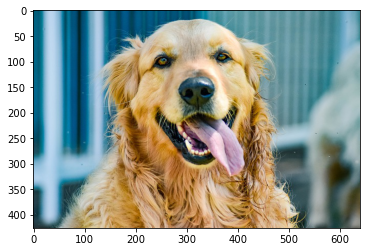

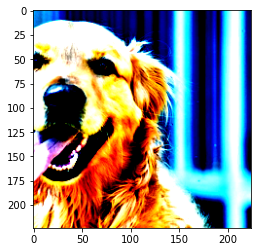

In [4]:
# 훈련시 화상 전처리 동작 확인
# 실행할 때마다 처리 결과 화상이 바뀜

# 1. 화상 읽기
image_file_path = './data/goldenretriever-3724972_640.jpg'
img = Image.open(image_file_path)   # [높이][폭][색RGB]

# 2. 원본 화상 표시
plt.imshow(img)
plt.show()

# 3. 화상 전처리, 처리된 화상을 표시
size = 224
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

transform = ImageTransform(size, mean, std)
img_transformed = transform(img, phase="train")  # torch.Size([3, 224, 224])

# (색상, 높이, 너비)를 (높이, 너비, 색상)으로 변환하고 0-1로 값을 제한해 표시
img_transformed = img_transformed.numpy().transpose((1, 2, 0))
img_transformed = np.clip(img_transformed, 0, 1)
plt.imshow(img_transformed)
plt.show()


In [6]:
# 개미와 벌의 화상 파일의 경로 리스트를 작성
def make_datapath_list(phase="train"):
    """
    데이터의 경로를 저장한 리스트를 작성한다.

    Parameters
    ----------
    phase : 'train' or 'val'
        훈련 데이터 또는 검증 데이터를 지정

    Returns
    -------
    path_list : list
        데이터 경로를 저장한 리스트
    """

    rootpath = "./data/hymenoptera_data/"
    target_path = osp.join(rootpath+phase+'/**/*.jpg')
    print(target_path)

    path_list = []  # 여기에 저장한다

    # glob을 이용하여 하위 디렉토리의 파일 경로를 가져온다
    for path in glob.glob(target_path):
        path_list.append(path)

    return path_list


# 실행
train_list = make_datapath_list(phase="train")
val_list = make_datapath_list(phase="val")

train_list


./data/hymenoptera_data/train/**/*.jpg
./data/hymenoptera_data/val/**/*.jpg


['./data/hymenoptera_data/train\\ants\\0013035.jpg',
 './data/hymenoptera_data/train\\ants\\1030023514_aad5c608f9.jpg',
 './data/hymenoptera_data/train\\ants\\1095476100_3906d8afde.jpg',
 './data/hymenoptera_data/train\\ants\\1099452230_d1949d3250.jpg',
 './data/hymenoptera_data/train\\ants\\116570827_e9c126745d.jpg',
 './data/hymenoptera_data/train\\ants\\1225872729_6f0856588f.jpg',
 './data/hymenoptera_data/train\\ants\\1262877379_64fcada201.jpg',
 './data/hymenoptera_data/train\\ants\\1269756697_0bce92cdab.jpg',
 './data/hymenoptera_data/train\\ants\\1286984635_5119e80de1.jpg',
 './data/hymenoptera_data/train\\ants\\132478121_2a430adea2.jpg',
 './data/hymenoptera_data/train\\ants\\1360291657_dc248c5eea.jpg',
 './data/hymenoptera_data/train\\ants\\1368913450_e146e2fb6d.jpg',
 './data/hymenoptera_data/train\\ants\\1473187633_63ccaacea6.jpg',
 './data/hymenoptera_data/train\\ants\\148715752_302c84f5a4.jpg',
 './data/hymenoptera_data/train\\ants\\1489674356_09d48dde0a.jpg',
 './data/hym

In [7]:
# 개미와 벌의 이미지에 대한 Dataset을 작성한다
class HymenopteraDataset(data.Dataset):
    """
    개미와 벌 화상의 Dataset 클래스. PyTorch의 Dataset 클래스를 상속한다.

    Attributes
    ----------
    file_list : 리스트
        화상 경로를 저장한 리스트
    transform : object
        전처리 클래스의 인스턴스
    phase : 'train' or 'test'
        학습인지 훈련인지를 설정한다.
    """

    def __init__(self, file_list, transform=None, phase='train'):
        self.file_list = file_list  # 파일 경로 리스트
        self.transform = transform  # 전처리 클래스의 인스턴스
        self.phase = phase  # train or val 지정

    def __len__(self):
        '''화상 개수를 반환'''
        return len(self.file_list)

    def __getitem__(self, index):
        '''
        전처리한 화상의 Tensor 형식의 데이터와 라벨을 취득
        '''

        # index번째의 화상을 로드
        img_path = self.file_list[index]
        img = Image.open(img_path)  # [높이][너비][색RGB]

        # 화상의 전처리를 실시
        img_transformed = self.transform(
            img, self.phase)  # torch.Size([3, 224, 224])

        # 화상 라벨을 파일 이름에서 추출
        if self.phase == "train":
            label = img_path[30:34]
        elif self.phase == "val":
            label = img_path[28:32]

        # 라벨을 숫자로 변경
        if label == "ants":
            label = 0
        elif label == "bees":
            label = 1

        return img_transformed, label


# 실행
train_dataset = HymenopteraDataset(
    file_list=train_list, transform=ImageTransform(size, mean, std), phase='train')

val_dataset = HymenopteraDataset(
    file_list=val_list, transform=ImageTransform(size, mean, std), phase='val')

# 동작 확인
index = 0
print(train_dataset.__getitem__(index)[0].size())
print(train_dataset.__getitem__(index)[1])


torch.Size([3, 224, 224])
0


# DataLoader 작성

In [8]:
# 미니 배치 크기 지정
batch_size = 32

# DataLoader 작성
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)

val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False)

# 사전형 변수에 정리
dataloaders_dict = {"train": train_dataloader, "val": val_dataloader}

# 동작 확인
batch_iterator = iter(dataloaders_dict["train"])  # 반복자(iterator)로 변환
inputs, labels = next(
    batch_iterator)  # 첫번째 요소를 추출
print(inputs.size())
print(labels)


torch.Size([32, 3, 224, 224])
tensor([1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1,
        0, 0, 1, 1, 0, 1, 0, 0])


# 네트워크 모델 작성

In [9]:
# 학습된 VGG-16 모델을 로드
# VGG-16 모델의 인스턴스 생성
use_pretrained = True  # 학습된 파라미터를 사용
net = models.vgg16(pretrained=use_pretrained)

# VGG16의 마지막 출력층의 출력 유닛을 개미와 벌의 2개로 바꾼다
net.classifier[6] = nn.Linear(in_features=4096, out_features=2)

# 훈련 모드로 설정
net.train()

print('네트워크 설정 완료: 학습된 가중치를 읽어들여 훈련 모드로 설정했습니다.')

네트워크 설정 완료: 학습된 가중치를 읽어들여 훈련 모드로 설정했습니다.


# 손실 함수 정의

In [10]:
# 손실 함수 설정
criterion = nn.CrossEntropyLoss()


# 최적화 기법 설정

In [11]:
# 전이학습에서 학습시킬 파라미터를 params_to_update 변수에 저장한다
params_to_update = []

# 학습시킬 파라미터 이름
update_param_names = ["classifier.6.weight", "classifier.6.bias"]

# 학습시킬 파라미터 이외에는 경사를 계산하지 않고, 변하지 않게 설정
for name, param in net.named_parameters():
    if name in update_param_names:
        param.requires_grad = True
        params_to_update.append(param)
        print(name)
    else:
        param.requires_grad = False

# params_to_update의 내용을 확인
print("-----------")
print(params_to_update)


classifier.6.weight
classifier.6.bias
-----------
[Parameter containing:
tensor([[-0.0133, -0.0051, -0.0067,  ...,  0.0068, -0.0040,  0.0070],
        [ 0.0063, -0.0014,  0.0149,  ..., -0.0018, -0.0116, -0.0079]],
       requires_grad=True), Parameter containing:
tensor([-0.0020, -0.0065], requires_grad=True)]


In [12]:
# 최적화 기법 설정
optimizer = optim.SGD(params=params_to_update, lr=0.001, momentum=0.9)


# 학습 및 검증 실시

In [13]:
# 모델을 학습시키는 함수를 작성
def train_model(net, dataloaders_dict, criterion, optimizer, num_epochs):

    # epoch 루프
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-------------')

        # epoch별 학습 및 검증 루프
        for phase in ['train', 'val']:
            if phase == 'train':
                net.train()  # 모델을 훈련 모드로
            else:
                net.eval()   # 모델을 검증 모드로

            epoch_loss = 0.0  # epoch 손실의 합
            epoch_corrects = 0  # epoch 정답의 수

            # 미 학습시 검증 성능을 확인하기 위해 epoch=0의 훈련 생략
            if (epoch == 0) and (phase == 'train'):
                continue

            # 데이터 로더로 미니 배치를 꺼내는 루프
            for inputs, labels in tqdm(dataloaders_dict[phase]):

                # optimizer를 초기화
                optimizer.zero_grad()

                # 순전파(forward) 계산
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = net(inputs)
                    loss = criterion(outputs, labels)  # 손실을 계산
                    _, preds = torch.max(outputs, 1)  # 라벨을 예측
                    
  
                    # 훈련시에는 오차 역전파
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                    # 반복 결과 계산
                    # loss 합계 갱신
                    epoch_loss += loss.item() * inputs.size(0)  
                    # 정답 수의 합계 갱신
                    epoch_corrects += torch.sum(preds == labels.data)

            # epoch 당 loss와 정답률 표시
            epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
            epoch_acc = epoch_corrects.double(
            ) / len(dataloaders_dict[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))


In [14]:
# 학습 및 검증 실시
num_epochs=2
train_model(net, dataloaders_dict, criterion, optimizer, num_epochs=num_epochs)

Epoch 1/2
-------------


100%|██████████| 5/5 [00:10<00:00,  2.10s/it]


val Loss: 0.7191 Acc: 0.4967
Epoch 2/2
-------------


100%|██████████| 8/8 [00:16<00:00,  2.04s/it]


train Loss: 0.4703 Acc: 0.7572


100%|██████████| 5/5 [00:09<00:00,  2.00s/it]

val Loss: 0.1673 Acc: 0.9477


끝